* https://towardsdatascience.com/transformers-141e32e69591
* https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
* https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9#:~:text=LSTMs%20use%20a%20series%20of,each%20their%20own%20neural%20network.
* https://stats.stackexchange.com/questions/365778/what-should-i-do-when-my-neural-network-doesnt-generalize-well
* https://www.youtube.com/watch?v=ROLugVqjf00
* https://lilianweng.github.io/posts/2019-03-14-overfit/    (very important)
* https://atcold.github.io/pytorch-Deep-Learning/en/week11/11-3/
* https://towardsdatascience.com/choosing-and-customizing-loss-functions-for-image-processing-a0e4bf665b0a
* https://towardsdatascience.com/learning-to-rank-a-complete-guide-to-ranking-using-machine-learning-4c9688d370d4
* https://embracingtherandom.com/machine-learning/tensorflow/ranking/deep-learning/learning-to-rank-part-2/#where-do-probabilities-fit-into-listnet
* https://www.topbots.com/attention-for-time-series-forecasting-and-classification/
* https://medium.com/@judopro/using-machine-learning-to-programmatically-determine-stock-support-and-resistance-levels-9bb70777cf8e  K-Means Algorithm used to identify the support and resistence levels.

In [1]:
NR_OF_BINS = 100
BACKWARD_WINDOW_LENGTH = 3
FORWARD_WINDOW_LENGTH = 1
INTERPLOATION_POINTS = 1200
EXCHANGE_RATES = ['EURUSD']

FROM_TIMESTAMP = '2022-09-01 00:00'
TO_TIMESTAMP = '2022-11-01 00:00'
FFT_AC_COEFFICIENT  = 15 

# LIBRARIES

In [2]:
import MetaTrader5 as mt5

import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from scipy import interpolate
from numpy.fft import fft,ifft

import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score

import pyspark
from pyspark.sql import SparkSession

# SOURCE DATA

In [3]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
tplSymbols = mt5.symbols_get()
dfSymbols = pd.DataFrame(tplSymbols, columns = tplSymbols[0]._asdict().keys())

In [4]:
# get OHLC data
dfOhlc = pd.DataFrame()
for sExchangeRate in EXCHANGE_RATES:
    
    df = pd.read_csv(r'Data\{}_M1_202010010001_202210312359.csv'.format(sExchangeRate), delimiter = '\t')
    df.loc[:, 'PRICE_TIME_STAMP'] = pd.to_datetime(df['<DATE>'] + df['<TIME>'], format='%Y.%m.%d%H:%M:%S')
    df.drop(['<DATE>', '<TIME>'], axis = 1, inplace = True)
    df.loc[:, 'EXCHANGE_RATE'] = sExchangeRate
    df.query('@FROM_TIMESTAMP<= PRICE_TIME_STAMP <= @TO_TIMESTAMP ', inplace = True)
    dfOhlc = pd.concat([dfOhlc, df])


# PREPROCESSING

In [5]:
def GET_DATASETS_1(dfPreprocessed, dfTimes):

    #Create PySpark SparkSession
    oSparkSess = SparkSession.builder \
        .master("local[1]") \
        .appName("SparkByExamples.com") \
        .config("spark.executor.memory", "70g") \
        .config("spark.driver.memory", "50g") \
        .config("spark.memory.offHeap.enabled",True) \
        .config("spark.memory.offHeap.size","16g")   \
        .getOrCreate()

    oSparkSess.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

    def dfGetPriceAnalysis(df, iFrom, iTo, dfTimes):
        
        df = df[['PRICE_TIME_STAMP','<CLOSE>', '<HIGH>']]

        sdf= oSparkSess.createDataFrame(df)
        sdf.createOrReplaceTempView("sdf")

        dfTimes['FROM_TIME_STAMP'] = dfTimes['TIME_STAMP'] + pd.DateOffset(hours=iFrom)
        dfTimes['TO_TIME_STAMP'] = dfTimes['TIME_STAMP'] + pd.DateOffset(hours=iTo)

        sdfTimes= oSparkSess.createDataFrame(dfTimes)
        sdfTimes.createOrReplaceTempView("sdfTimes")

        dfToReturn =  oSparkSess.sql("""
            SELECT *
            FROM
            (
                SELECT 
                t.*,
                df.`<CLOSE>` AS CURRENT_CLOSE,
                df2.`<HIGH>` AS HISTORY_HIGH,
                (df2.`<HIGH>`-df.`<CLOSE>`)/(df.`<CLOSE>`) AS DIFF
                FROM
                (
                    SELECT df1.*, df2.TIME_STAMP AS HISTORY_TIME_STAMP FROM sdfTimes df1
                    INNER JOIN sdfTimes df2
                    ON df2.TIME_STAMP >= df1.FROM_TIME_STAMP and df2.TIME_STAMP < df1.TO_TIME_STAMP
                ) t
                LEFT JOIN sdf df
                ON t.TIME_STAMP = df.PRICE_TIME_STAMP
                LEFT JOIN sdf df2
                ON t.HISTORY_TIME_STAMP = df2.PRICE_TIME_STAMP
            ) df
            ORDER BY df.TIME_STAMP, df.HISTORY_TIME_STAMP
        """).toPandas()
        # find the unique timestamps where there is no historical or current data. and drop them from the dataset.
        aTimeStampsToDrop = dfToReturn.query('CURRENT_CLOSE.isna() == True or HISTORY_HIGH.isna() == True')['TIME_STAMP'].unique()
        dfToReturn.query('TIME_STAMP not in @aTimeStampsToDrop', inplace = True)
        dfToReturn.reset_index(drop = True, inplace = True)

        # drop the time stamps where there is no 60-mins data avaiable
        aTimeStampsToDrop = dfToReturn.groupby(['TIME_STAMP']).count().reset_index().query('HISTORY_TIME_STAMP < 60')['TIME_STAMP'].unique()
        dfToReturn.query('TIME_STAMP not in @aTimeStampsToDrop', inplace = True)
        dfToReturn.reset_index(drop = True, inplace = True)    

        dfToReturn.loc[:, 'MINUTE_DIFF'] = ((dfToReturn.loc[:, 'HISTORY_TIME_STAMP']-dfToReturn.loc[:, 'FROM_TIME_STAMP']).dt.seconds/60).astype(int)
        return dfToReturn



    dfPrep = dfPreprocessed.copy()

    aExchangeRates = list(dfPrep['EXCHANGE_RATE'].unique())

    dicDatasets = {
        'INPUT':
        {
        },
        'OUTPUT':
        {   
        }
    }
    
    
    for sExchangeRate in aExchangeRates:
        df_single_exc = dfPrep.query('EXCHANGE_RATE == @sExchangeRate')
        df_single_exc = df_single_exc[['PRICE_TIME_STAMP','<CLOSE>', '<HIGH>']].fillna(0)

        dic_input_single_exc = {}
        for i in range(-BACKWARD_WINDOW_LENGTH, 0):
            iFrom = i
            iTo = i +1

            print(iFrom)
            dfPriceAnalysis = dfGetPriceAnalysis(df_single_exc, iFrom, iTo, dfTimes)

            dic_input_single_exc[iFrom] = dfPriceAnalysis



        dic_output_single_exc = {}
        for i in range(0, FORWARD_WINDOW_LENGTH):
            iFrom = i
            iTo = i +1

            print(iFrom)
            dfPriceAnalysis = dfGetPriceAnalysis(df_single_exc, iFrom, iTo, dfTimes)

            dic_output_single_exc[iFrom] = dfPriceAnalysis


        dicDatasets['INPUT'][sExchangeRate] = dic_input_single_exc
        dicDatasets['OUTPUT'][sExchangeRate] = dic_output_single_exc

    
    
    # identify common time stamps
    aCommonTimeStamps = list()
    for i in dicDatasets:
        for j in dicDatasets[i]:
            for k in dicDatasets[i][j]:
                df = dicDatasets[i][j][k]

                if len(aCommonTimeStamps) == 0:
                    aCommonTimeStamps = df['TIME_STAMP'].unique()
                else:
                    aCommonTimeStamps = np.intersect1d(aCommonTimeStamps, df['TIME_STAMP'].unique())


    # drop the datafrom datasets that don't have common time stamps
    for i in dicDatasets:
        for j in dicDatasets[i]:
            for k in dicDatasets[i][j]:
                df = dicDatasets[i][j][k]
                dicDatasets[i][j][k] = df.query('TIME_STAMP in @aCommonTimeStamps').reset_index(drop = True)



    def dfCompileDic(p_dic, tplFormat,sKey):
        aToReturn =  np.zeros(tplFormat)
        dic = p_dic[sKey]
        ixExcRate = 0
        for i in dic:
            ixTimeStep = 0
            for j in dic[i]:
                df = dic[i][j]
                df = pd.pivot_table(
                    data = df[['DIFF','MINUTE_DIFF', 'TIME_STAMP']], 
                    values='DIFF', index='TIME_STAMP',
                    columns='MINUTE_DIFF', 
                    aggfunc=np.sum
                )
                df.sort_index(ascending=True, inplace=True)

                aToReturn[:, ixTimeStep,:,ixExcRate] = df.values

                ixTimeStep = ixTimeStep + 1

            ixExcRate = ixExcRate  + 1


        return aToReturn

    def aGetTimeFeatures(aTimeStamps):
        df =pd.DataFrame(data = aTimeStamps, columns = ['TIME_STAMP'])
        df.sort_values(by = 'TIME_STAMP' , ascending=True, inplace=True)
        df.loc[:, 'MINUTE'] = pd.to_datetime(df.loc[:, 'TIME_STAMP'],unit='s').dt.minute
        df.loc[:, 'HOUR'] = pd.to_datetime(df.loc[:, 'TIME_STAMP'],unit='s').dt.hour
        df.loc[:, 'DAY_OF_WEEK'] = pd.to_datetime(df.loc[:, 'TIME_STAMP'],unit='s').dt.day_of_week
        df.loc[:, 'DAY_OF_MONTH'] = pd.to_datetime(df.loc[:, 'TIME_STAMP'],unit='s').dt.day
        df.drop('TIME_STAMP', axis = 1, inplace = True)
        aToReturn = df.values
        return aToReturn
    
    

    X = dfCompileDic(dicDatasets, (len(aCommonTimeStamps), BACKWARD_WINDOW_LENGTH , 60 , len(aExchangeRates)), 'INPUT') # sample_size, time_steps, features, channel_size
    Y = dfCompileDic(dicDatasets, (len(aCommonTimeStamps), FORWARD_WINDOW_LENGTH , 60 , len(aExchangeRates)), 'OUTPUT') # sample_size, time_steps, features, channel_size
    X_TIME= aGetTimeFeatures(aCommonTimeStamps) #sample size, features
    
    return X,Y,X_TIME


# VASWANI'S ATTENTION

In [6]:
dfPrep = dfOhlc.copy()
dfTimeStamps = pd.DataFrame(
    data = pd.date_range(
        start=FROM_TIMESTAMP, 
        end=TO_TIMESTAMP, freq = 'min'
    ),
    columns  = ['TIME_STAMP']
)
dfTimeStamps.query('TIME_STAMP.dt.day_of_week not in (6,7)', inplace = True)
dfTimeStamps.reset_index(drop = True, inplace = True)

X_ORIGINAL, Y_ORIGINAL, X_TIME_ORIGINAL = GET_DATASETS_1(dfPrep, dfTimeStamps)

-3
-2
-1
0


In [60]:
# reduce dimension of input dataset with fast fourier transform
X = np.zeros((X_ORIGINAL.shape[0], X_ORIGINAL.shape[1], FFT_AC_COEFFICIENT, X_ORIGINAL.shape[3]))
for i in range(X_ORIGINAL.shape[1]): #future time step
    for j in range(X_ORIGINAL.shape[3]): #exchange rate
        aTransformed = fft(X_ORIGINAL[:, i,:,j])
        aTransformed = aTransformed[:, :FFT_AC_COEFFICIENT]
        aInverseTransformed = ifft(aTransformed)
        X[:, i,:,j] = aInverseTransformed
        
        

Y= Y_ORIGINAL.copy()
# handle outliers below 0.10th and above .90th quantiles
fLowerBound = np.quantile(Y.reshape(-1,1), 0.10)
fUpperBound =np.quantile(Y.reshape(-1,1), 0.90)

Y[Y<fLowerBound] = fLowerBound
Y[Y>fUpperBound] = fUpperBound



Y_copy = Y.copy()
# interplating Y dataset (as data augmentation ?)
Y = np.zeros((Y_copy.shape[0], Y_copy.shape[1], INTERPLOATION_POINTS, Y_copy.shape[3]))
for i in range(Y_copy.shape[1]): #future time step
    for j in range(Y_copy.shape[3]): #exchange rate
        aX = list(range(0,60))
        aY = Y_copy[:, i,:,j]

        oInterpolate = interpolate.interp1d(aX, aY, kind = 'linear')

        aX_new = np.linspace(0, 59, INTERPLOATION_POINTS)
        aY_new = oInterpolate(aX_new)
        
        Y[:, i,:,j] = aY_new
        
    
        
# # # discritize output to histogram bin size
aHistogramBins = np.linspace(fLowerBound,fUpperBound, num = INTERPLOATION_POINTS).reshape(-1 ,1)
oOutputDiscritizer = KBinsDiscretizer(n_bins = NR_OF_BINS, encode = 'ordinal', strategy = 'uniform')
aBins = oOutputDiscritizer.fit_transform(aHistogramBins).astype(int)
Y = oOutputDiscritizer.transform(Y.reshape(-1,1)).reshape(Y.shape).astype(int)


# calculate frequencies
Y_copy = Y.copy()
Y = np.zeros((Y_copy.shape[0], Y_copy.shape[1], NR_OF_BINS, Y_copy.shape[3]))
for i in range(Y_copy.shape[1]): #future time step
    for j in range(Y_copy.shape[3]): #exchange rate
        aOriginal = Y_copy[:, i,:,j]
        df = pd.DataFrame(aOriginal).melt(ignore_index = False)
        df.reset_index(inplace = True)
        df = pd.pivot_table(df , columns = 'value', index = 'index', values = 'variable', aggfunc='count', fill_value=0)
        Y[:, i,:,j] = df.values

Y = Y/INTERPLOATION_POINTS    


# split data to train-validation-test
c_fTrainingRatio = 0.70
c_fValidationRatio = 0.28
c_fTestRatio = 0.02

X_train,X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=1-c_fTrainingRatio,
    shuffle=False,
    random_state = 1
)

X_validation, X_test,Y_validation, Y_test = train_test_split(
    X_test,Y_test,
    test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
    shuffle=False,
    random_state = 1
)

X_train = X_train[:,:,:,0]
X_validation = X_validation[:,:,:,0]
X_test = X_test[:,:,:,0]

Y_train = Y_train[:,0,:,0]
Y_validation = Y_validation[:,0,:,0]
Y_test = Y_test[:,0,:,0]

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [72]:
X_train.shape

(41133, 100)

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer


class Time2Vec(Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)

        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))


def transformer_encoder(inputs):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=512, num_heads=4, dropout=0.1)(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)

    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return res


TermInput = tf.keras.Input(
    shape=(BACKWARD_WINDOW_LENGTH, FFT_AC_COEFFICIENT)
)

# TimeInput = tf.keras.Input(
#     shape=(BACKWARD_WINDOW_LENGTH, X_TIME_train.shape[2]))

# W = Time2Vec(1)(TimeInput)
# W = tf.keras.layers.concatenate([TermInput, W], -1)

W = TermInput
# W = tf.keras.layers.Flatten()(W)
 
# for _ in range(1):
#     W = transformer_encoder(W)
    
# W = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(W)
for _ in range(3):
    W = tf.keras.layers.Dense(128)(W)
    W = tf.keras.layers.ReLU()(W)
    W = tf.keras.layers.Dropout(0.5)(W)

W = tf.keras.layers.Flatten()(W)
W = tf.keras.layers.Dense(NR_OF_BINS, activation = 'sigmoid')(W)
# W = tf.keras.layers.Softmax(axis = 2)(W)
# W = tf.keras.layers.Reshape((Y_train.shape[2]))(W)


ModelOutput = W
oModel = tf.keras.Model(TermInput, ModelOutput, name = 'TRANSFORMER_MODEL')

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-04)
oModel.compile(
    loss = tf.keras.losses.MeanSquaredError(), 
    optimizer=oOptimizer
)

# # print(oModel.summary())

tf.keras.utils.plot_model(oModel, show_shapes=True)


# fit model
oEarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 50, 
    restore_best_weights = True,
    start_from_epoch= 8000
)

oModel.fit(
    X_train, 
    Y_train, 
    epochs= 10**4, 
    batch_size=2**10, 
    verbose=1, 
    validation_data= (X_validation, Y_validation),
    # callbacks=[oEarlyStop]
)

# show epoch history
dfHistory = pd.DataFrame(oModel.history.history)

plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')
plt.show()

1286/1286 [==============================] - 4s 3ms/step


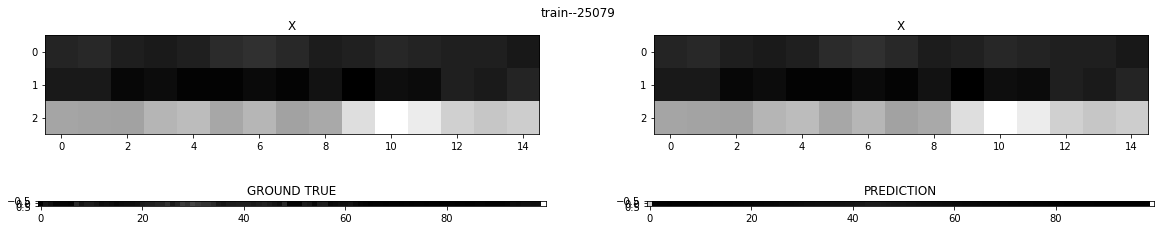

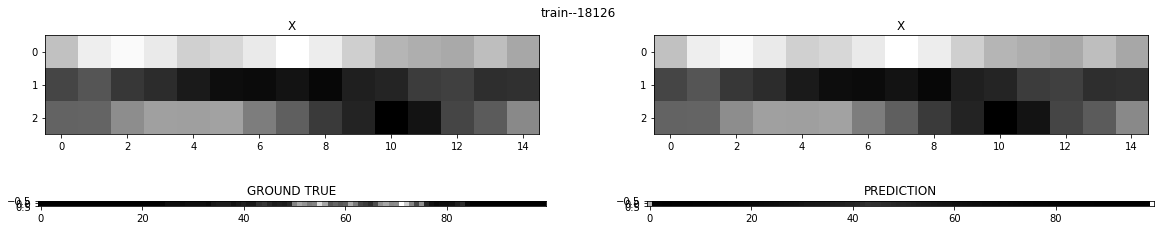

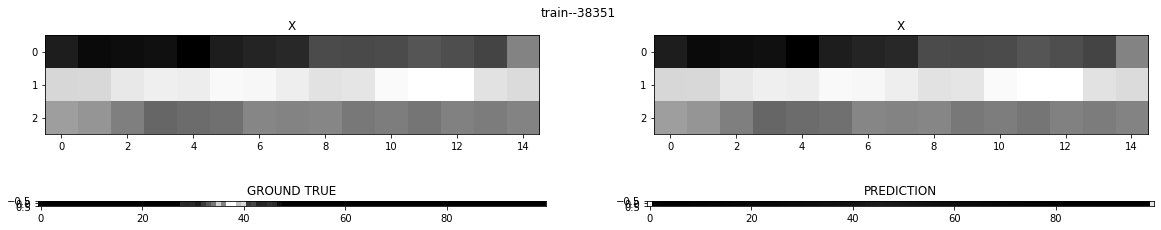

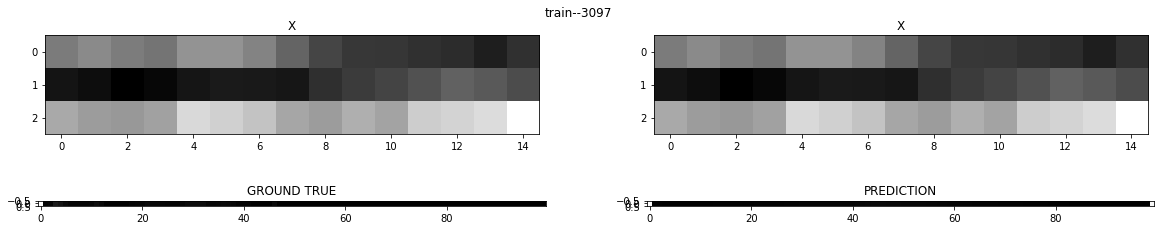

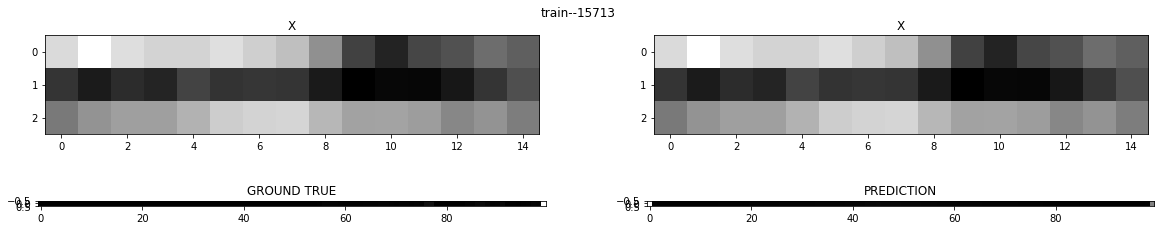

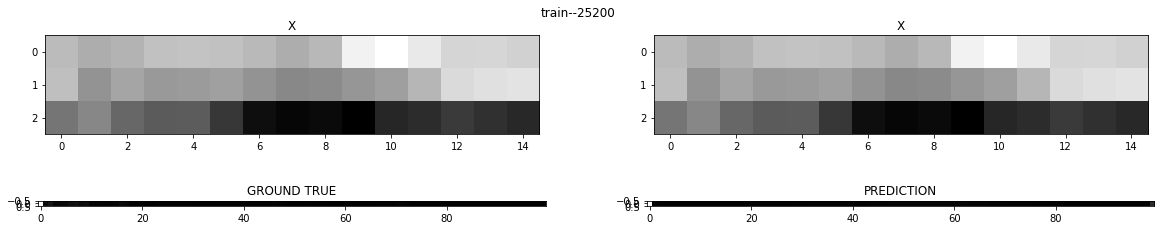

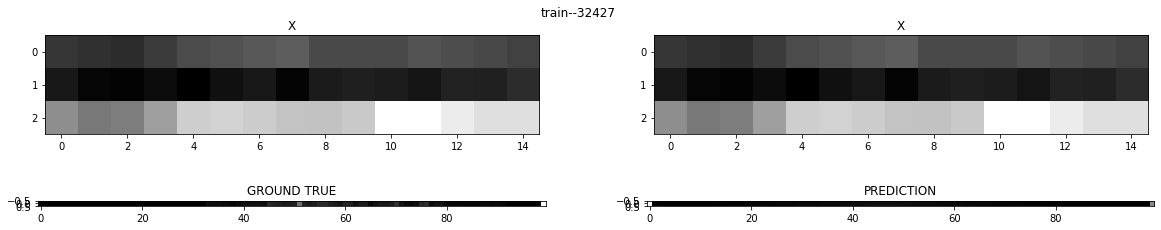

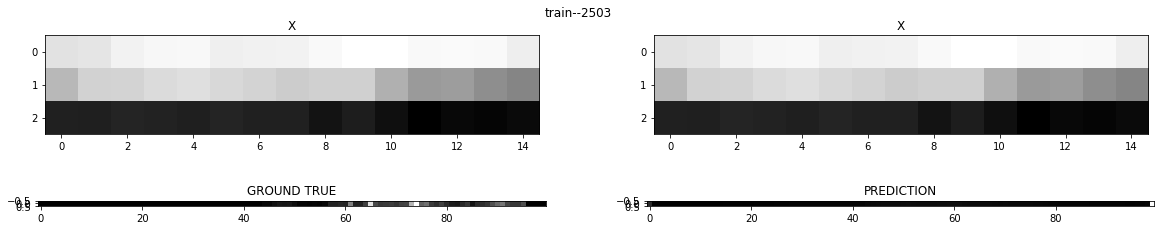

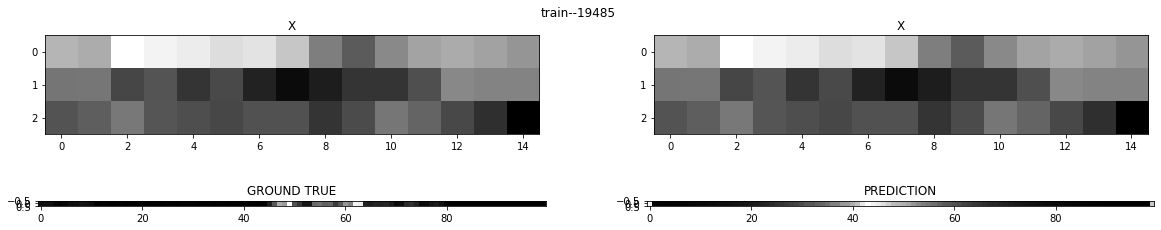

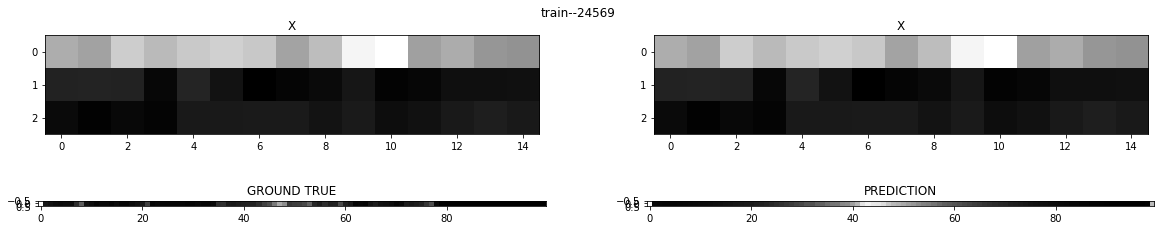

515/515 [==============================] - 1s 2ms/step


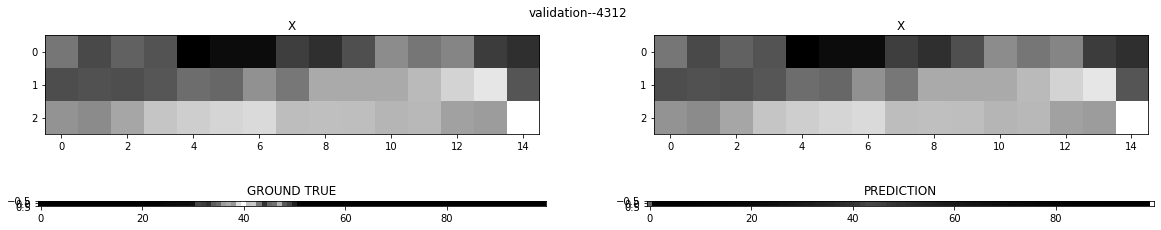

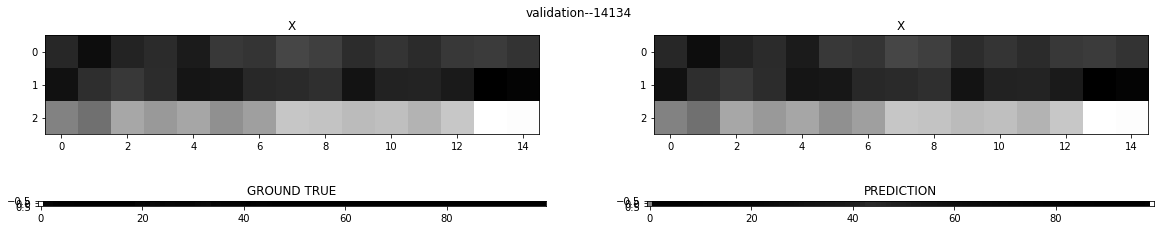

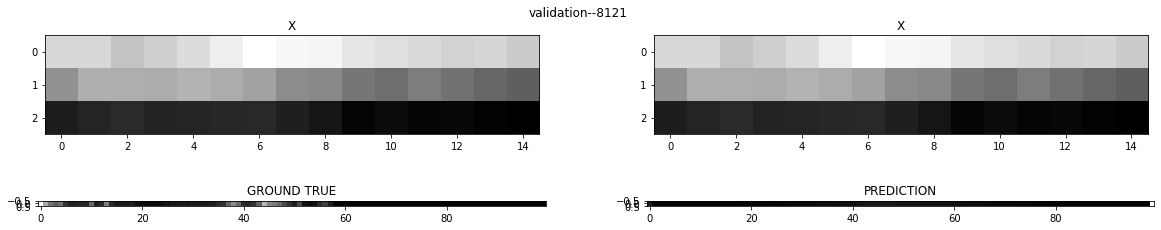

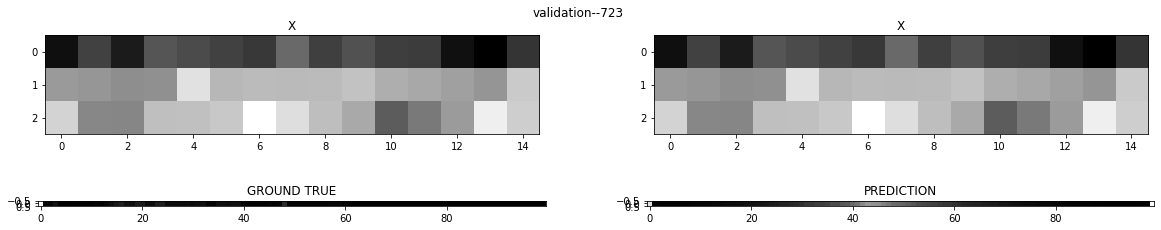

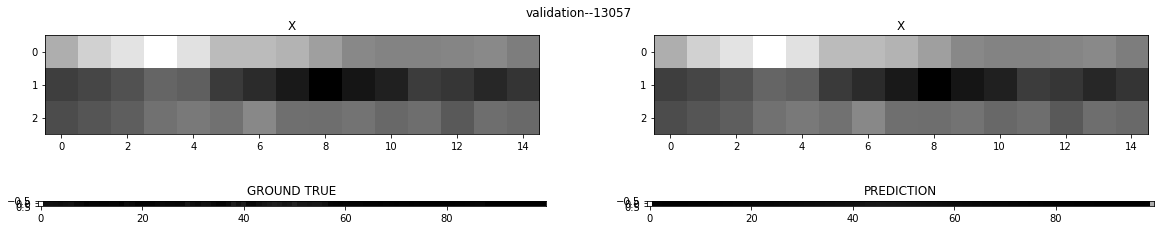

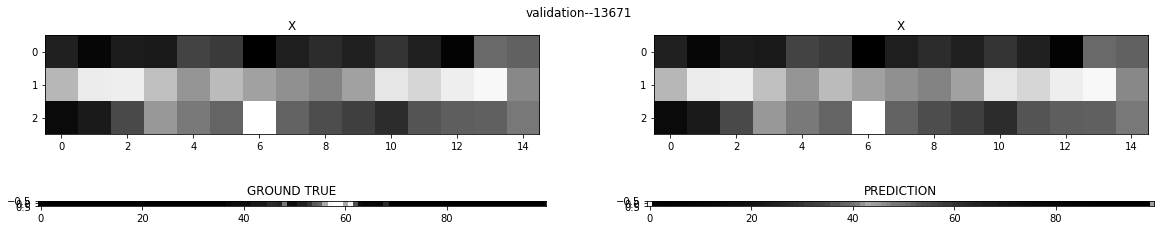

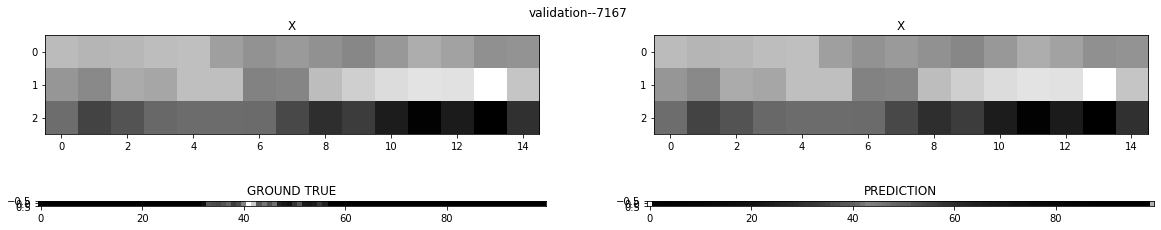

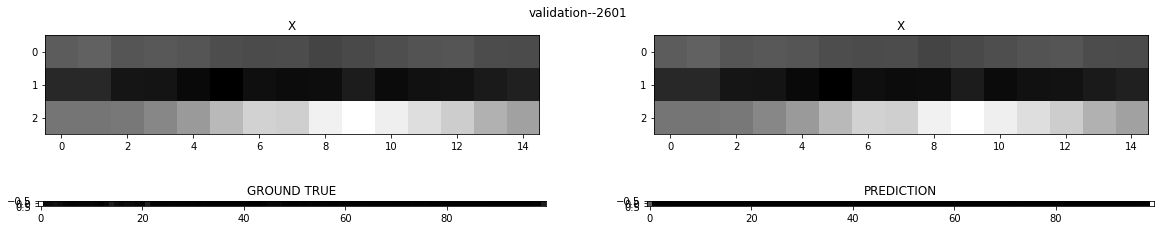

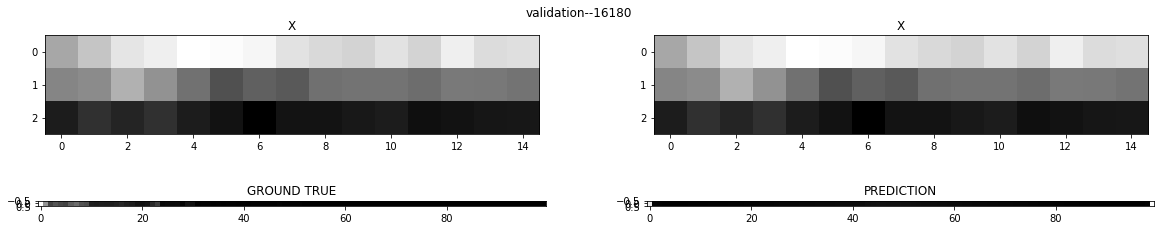

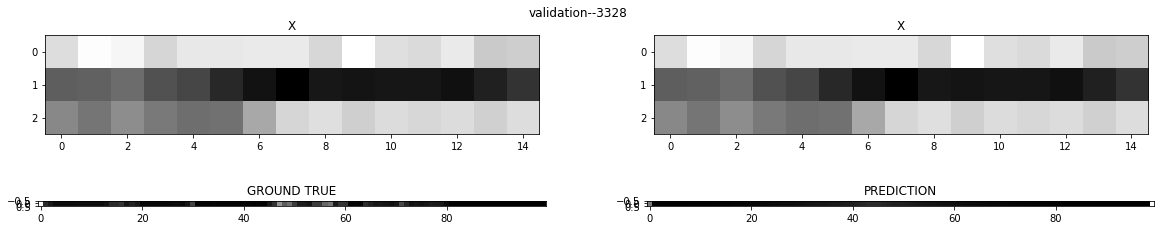

In [70]:
# test model
a_Y_datasets = [Y_train, Y_validation]
a_X_datasets = [X_train, X_validation]
a_labels = ['train', 'validation'] 
for X_to_visualzie,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualzie)
    ground_true = Y_to_visualize
    for i in np.random.randint(low = 0,high = len(X_to_visualzie), size = 10):      
        
        fig, axs = plt.subplots(2,2, figsize=(20, 4))
        fig.suptitle('{}--{}'.format(sLabel, i))
        
        axs[0, 0].imshow(X_to_visualzie[i], cmap='gray')
        axs[0, 0].set_title( 'X')

        axs[0, 1].imshow(X_to_visualzie[i], cmap='gray')
        axs[0, 1].set_title( 'X')

    
        axs[1, 0].imshow(ground_true[[i]], cmap='gray')
        axs[1, 0].set_title( 'GROUND TRUE')

        axs[1, 1].imshow(pred[[i]], cmap='gray')
        axs[1, 1].set_title( 'PREDICTION')

        plt.show()